# Conditional Motif Enrichment

This notebook demonstrates how to perform conditional motif enrichment using the TissueMosaic representations.

In [1]:
## import statements

from matplotlib import pyplot as plt
import seaborn as sns
import scanpy
import pandas
from typing import Tuple, Any, List, Union
import numpy as np
import torch
import os
from anndata import read_h5ad
from scanpy import pp
import pandas as pd
import scanpy as sc
from scipy import sparse
import anndata as Anndata
import random

import matplotlib.gridspec as gridspec

# tissuemosaic import
import tissuemosaic as tp

In [2]:
from tissuemosaic.utils import *
from tissuemosaic.utils.anndata_util import *
from tissuemosaic.plots import *
from tissuemosaic.plots.plot_misc import *
from tissuemosaic.models.patch_analyzer import SpatialAutocorrelation, Composition
from tissuemosaic.data.dataset import MetadataCropperDataset
from tissuemosaic.genex.gene_utils import *

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


In [3]:
## path names
anndata_dest_folder = os.path.abspath("../../TissueMosaic_Figures/TissueMosaic_output/testis/testis_anndata_model_small_patch_featurized")

# dino_testis_global_large_local_small.pt

# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(anndata_dest_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['wt3_dm.h5ad', 'wt1_dm.h5ad', 'diabetes2_dm.h5ad', 'wt2_dm.h5ad', 'diabetes1_dm.h5ad', 'diabetes3_dm.h5ad']


In [4]:
## Read in anndatas and add metadata

anndata_list = []

for i,fname in enumerate(fname_list):
    adata = read_h5ad(os.path.join(anndata_dest_folder, fname))
    ## add metadata regarding sample condition
    if "wt" in fname:
        adata.obs['classify_condition'] = np.repeat(0,adata.obs.shape[0])
    else:
        adata.obs['classify_condition'] = np.repeat(1,adata.obs.shape[0])

    ## add metadata regarding sample id
    adata.obs['sample_id'] = i * np.ones(adata.obs.shape[0])
    
    ## add metadata regarding majority cell type at each spot
    adata.obs['cell_type'] = adata.obsm['cell_type_proportions'].idxmax(axis=1)
    
    ## filter out outlier spot features
    adata.obsm['dino'][adata.obsm['dino'] > 2.0] = 0
    
    anndata_list.append(adata)

In [5]:
merged_anndata = merge_anndatas_inner_join(anndata_list)
adata = merged_anndata
adata

/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 187422 × 21057
    obs: 'x', 'y', 'UMI', 'cell_type', 'dino_spot_features_valid', 'train_test_fold_1', 'train_test_fold_2', 'train_test_fold_3', 'train_test_fold_4', 'classify_condition', 'sample_id'
    obsm: 'cell_type_proportions', 'dino', 'dino_spot_features', 'ncv_k10', 'ncv_k100', 'ncv_k25', 'ncv_k50', 'ncv_k500'

In [6]:
from tissuemosaic.models.ssl_models._ssl_base_model import classify_and_regress
from sklearn.linear_model import RidgeClassifierCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/skambha6/miniforge3/en

## Run motif enrichment
We do this by training a classifier on the dino features and predicting the class labels of held out data.
We repeat this across the 4 spatially partitioned train/test folds

In [7]:
## Run enrichment on motifs (in cell-type agnostic manner) 

import warnings
warnings.filterwarnings('ignore')

feature_key = "dino_spot_features"

all_folds_test_anndatas = []


## Train classifier on spatially partitioned train/test folds
for kfold in range(1,5):

    print(f"Running kfold {kfold}")
    
    ## spatial split
    train_anndata = adata[adata.obs[f'train_test_fold_{kfold}'] == 0]
    test_anndata = adata[adata.obs[f'train_test_fold_{kfold}'] == 1]

    ## balance after train/test split b/c of spatial partitioning to downsample majority class
    print("Train data")
    train_anndata = balance_anndata(train_anndata, 'classify_condition')
    
    ## Train classifier
    classifier = RidgeClassifierCV(alphas=[1000.0, 2500.0, 5000.0]) ## set high regularization b/c of noisy labels in training data
    classifier.fit(train_anndata.obsm[feature_key], train_anndata.obs['classify_condition'])

    print(classifier.alpha_)

    print("Fit alpha:")
    print(classifier.alpha_)

    ## Confirm train/test scores are similar to ensure regularization worked as expected
    print("Train score:")
    print(classifier.score(train_anndata.obsm[feature_key], train_anndata.obs['classify_condition']))

    print("Test score:")
    print(classifier.score(test_anndata.obsm[feature_key], test_anndata.obs['classify_condition']))
    
    ## Get conditional motif enrichment from trained classifier and write to anndata
    predicted_condition = classifier.decision_function(test_anndata.obsm[feature_key])
    test_anndata.obs['predicted_condition'] = predicted_condition
    all_folds_test_anndatas.append(test_anndata)


Running kfold 1
Train data
1000.0
Fit alpha:
1000.0
Train score:
0.6188625056207482
Test score:
0.5682037345489611
Running kfold 2
Train data
1000.0
Fit alpha:
1000.0
Train score:
0.611872009569378
Test score:
0.5972542901716069
Running kfold 3
Train data
1000.0
Fit alpha:
1000.0
Train score:
0.6130839161886504
Test score:
0.5864572498439775
Running kfold 4
Train data
1000.0
Fit alpha:
1000.0
Train score:
0.6123540151273654
Test score:
0.6000087659705025


In [8]:
## Merge test folds together

all_test_anndatas = merge_anndatas_inner_join(all_folds_test_anndatas)

We can look at the conditional motif enrichment and compare to the arrangement of cell types in space of a diabetic sample. The visually disordered regions appear to correlate with the predicted diabetic motifs. This is further quantified by 'ES Purity' in the paper. The motifs with highest diabetic enrichment could be chosen for subsequent analysis.

Text(0.5, 1.0, 'Predicted Condition')

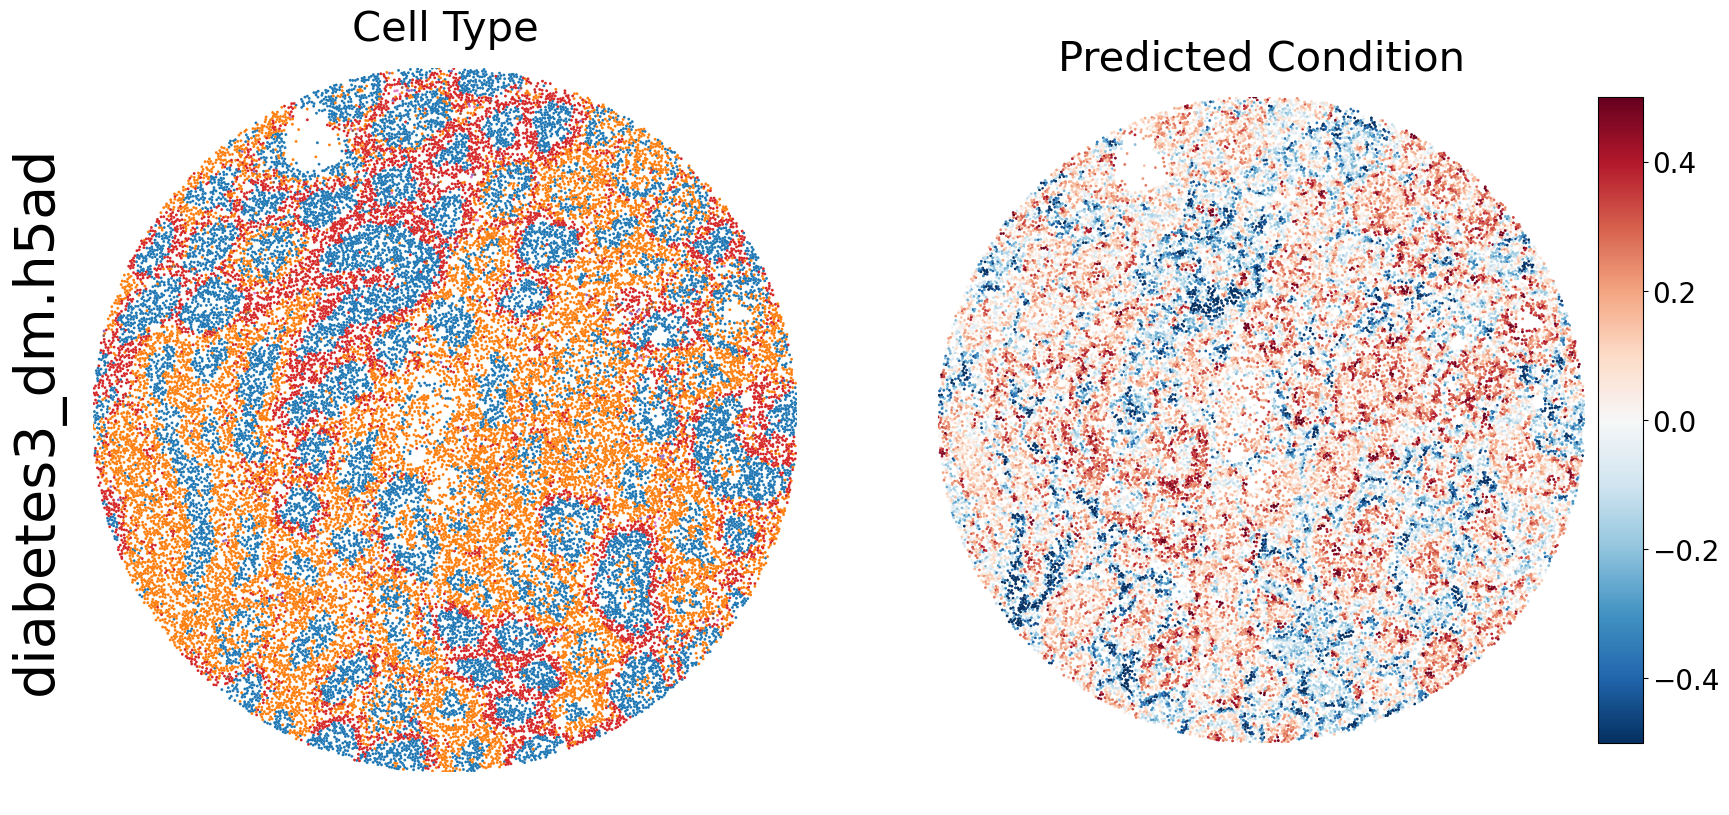

In [9]:
## Plotting utils

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# assign color to cell type
cdict = {
    'ES': colors[0],
    'RS': colors[1],
    'Myoid': colors[2],
    'SPC': colors[3],
    'SPG': colors[4],
    'Sertoli': colors[5],
    'Leydig': colors[6],
    'Endothelial': colors[7],
    'Macrophage': colors[8]
}

s = 5.0

## look at diabetes3_dm as example

sample_id = np.where(np.array(fname_list) == 'diabetes3_dm.h5ad')[0][0]

enriched_diabetic_sample = all_test_anndatas[all_test_anndatas.obs['sample_id'] == sample_id]

fig, axes = plt.subplots(figsize=(20, 10))
axes.set_axis_off()
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])

## plot cell types in space
scatter(enriched_diabetic_sample, 'cell_type', mode="categorical", x_key="y", y_key="x", s=s,cdict=cdict, fig=fig, ax=ax1, show_legend=False)
ax1.set_ylabel(fname_list[sample_id], fontsize=40, labelpad = 20)
ax1.set_title('Cell Type', fontsize=30, pad=20)
ax2 = fig.add_subplot(gs[0, 1])

## plot conditional motif enrichment in space
scatter(enriched_diabetic_sample, 'predicted_condition', x_key="y", y_key="x", s=s,cdict=cdict, show_legend=False, fig=fig, ax=ax2, vmin=-0.5, vmax=0.5)
ax2.set_title('Predicted Condition', fontsize=30, pad=20)